#### In this notebook, I will train a conditional flow to add RA and Dec, and I will use the LSST Error Model to add errors.

In [1]:
import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import corner
import pandas as pd

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.distributions import Uniform

In [2]:
# plotting style
plt.style.use('../paper.mplstyle')
twocol = 7.1014
onecol = 3.35
mpl.rcParams["xtick.major.size"] = 2.5
mpl.rcParams["ytick.major.size"] = 2.5

#### Load the DC2 Data

In [3]:
data = pd.read_pickle("dc2.pkl")
data

,redshift,u,g,r,i,z,y,ra,dec,size,ellipticity
0,0.088567,26.408892,25.052967,24.382580,24.054487,23.862051,23.780313,68.140241,-36.593690,0.228518,0.063050
1,1.669109,27.594755,27.341902,26.978935,26.064869,25.297333,24.829222,63.595239,-42.737808,0.157922,0.103562
2,1.159747,25.647858,25.738802,25.805744,25.816053,25.336340,25.312277,65.058580,-34.124349,0.044984,0.077182
3,1.243086,20.772106,20.849342,21.003485,21.068716,20.777245,20.585878,67.102727,-37.531376,0.731108,0.068541
4,0.495375,27.616890,26.316532,25.005684,24.470062,24.259823,24.124353,60.895633,-37.089175,0.136636,0.690425
...,...,...,...,...,...,...,...,...,...,...,...
999995,1.801396,25.059799,24.743279,24.634626,24.544033,24.275795,24.118439,67.129082,-45.451003,0.188007,0.284175
999996,1.704218,25.937052,25.833080,25.912664,25.534258,25.070293,24.750761,62.435367,-39.432315,0.318020,0.093354
999997,0.149601,26.392920,25.087479,24.551336,24.330084,24.194437,24.139854,67.479172,-37.236422,0.411841,0.412781
999998,1.556581,25.935816,25.960798,26.087328,25.866976,25.731079,25.296770,63.362970,-42.674246,0.266826,0.102412


In [4]:
# create training and test sets
trainset = data.sample(frac = 0.8, random_state = 0).sort_index()
testset = data.drop(trainset.index)
del data

#### Create a conditional flow to model RA and Dec as a function of redshift and colors

Note that because the RA and Dec in this set are fairly concentrated on the sky, I won't use circular splines, but since the RA and Dec have sharp cutoffs, I will use uniform distributions.

In [5]:
cols = trainset.columns[-4:]
conditional_columns = trainset.columns[:-4]

# pick means and stds so that each has domain (-5, 5)
stds = np.array((trainset[cols].max() - trainset[cols].min()).values / 10)
means = np.array(trainset[cols].min().values + 5 * stds)

# construct our bijector
bijector = Chain(
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers=cols.size, n_conditions=conditional_columns.size, B=5),
)

latent = Uniform((-5, 5), (-5, 5), (-5, 5), (-5, 5))

cflow = Flow(cols, bijector, latent=latent,
             conditional_columns=conditional_columns)

We should standard scale the conditional columns before interaction with the flow. Let's create a function to do this for us

In [6]:
M = trainset[conditional_columns].mean()
S = trainset[conditional_columns].std()
def condition_scaler(data):
    scaled_data = data.copy()
    scaled_data[conditional_columns] = (data[conditional_columns] - M) / S
    return scaled_data

#### Train the flow

In [7]:
%%time
losses = cflow.train(condition_scaler(trainset), epochs=50, verbose=True)

Training 50 epochs 
Loss:
5.2928
2.5553
2.4578
2.4438
2.4100
2.4029
2.3901
2.3969
2.3811
2.3758
2.3651
2.3593
2.3598
2.3587
2.3590
2.3496
2.3609
2.3494
2.3506
2.3499
2.3427
2.3527
2.3435
2.3403
2.3423
2.3410
CPU times: user 2h 20min 9s, sys: 23min 2s, total: 2h 43min 11s
Wall time: 30min 49s


Print the test loss

In [10]:
-np.mean(cflow.log_prob(condition_scaler(testset)))

DeviceArray(2.3690398, dtype=float32)

#### Plot the results

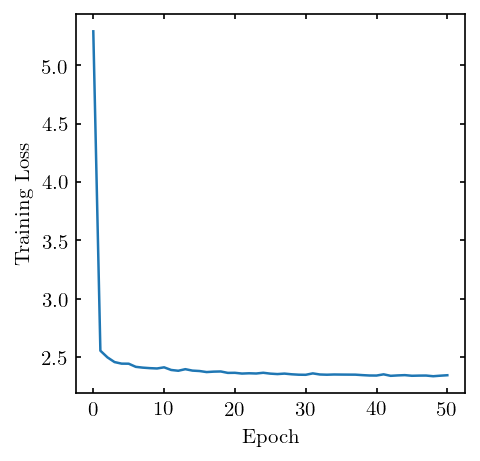

In [11]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

In [32]:
samples = cflow.sample(1, conditions=condition_scaler(testset[:10000]), seed=0)
samples[conditional_columns] = testset[:10000][conditional_columns].values
samples = samples[list(conditional_columns) + list(cols)]

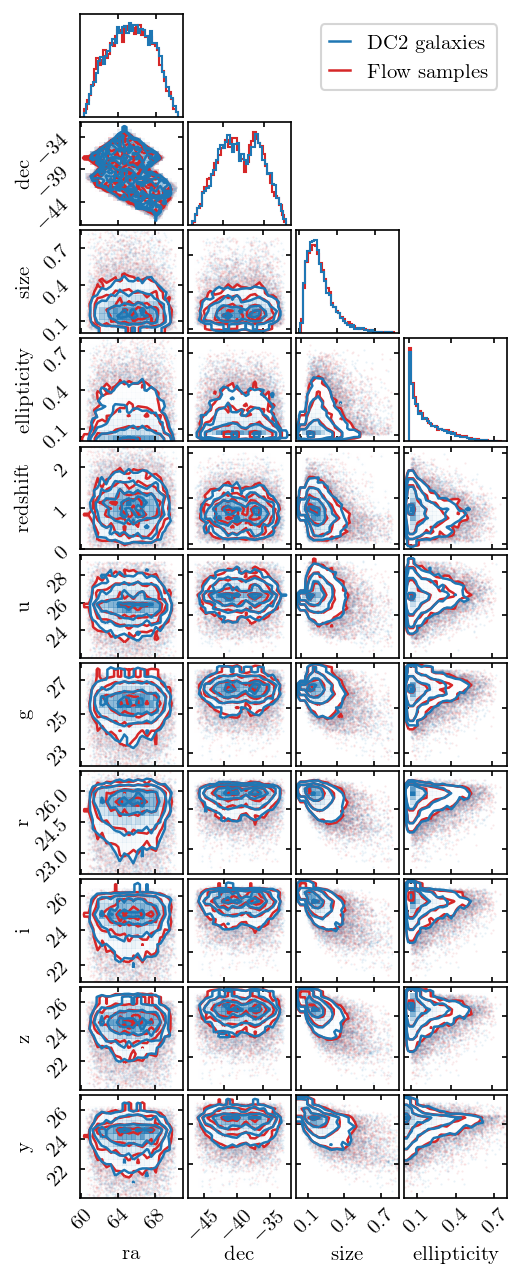

In [34]:
fig = plt.figure(figsize=(10/4*onecol, 10/4*onecol))

new_order = list(cols) + list(conditional_columns)

corner.corner(samples[new_order], fig=fig, color='C3', bins=20, hist_bin_factor=2, data_kwargs={'ms':2, "marker":"."})

corner.corner(testset[:10000][new_order], fig=fig, bins=20, hist_bin_factor=2, color='C0', data_kwargs={"marker":"."},
              labels=new_order, labelpad=0.15, max_n_ticks=3);

# extract the axes
axes = onp.array(fig.axes).reshape((len(new_order), len(new_order)))

# create the legend
axes[0,3].plot([], [], c="C0", label="DC2 galaxies")
axes[0,3].plot([], [], c="C3", label="Flow samples")
axes[0,3].legend(handlelength=1, loc="upper right")

# set the ticks
axes[1,0].set(yticks=[-44, -39, -34])
axes[2,0].set(ylim=(0, 0.85), yticks=[0.1, 0.4, 0.7])
axes[3,0].set(ylim=(0, 0.8), yticks=[0.1, 0.4, 0.7])
axes[4,0].set(ylim=(0, 2.5), yticks=[0, 1, 2])
axes[5,0].set(ylim=(22, 29.5), yticks=[24, 26, 28])
axes[6,0].set(ylim=(22, 28), yticks=[23, 25, 27])
axes[7,0].set(ylim=(22, 27), yticks=[23, 24.5, 26])
axes[8,0].set(ylim=(21, 27), yticks=[22, 24, 26])
axes[9,0].set(ylim=(20, 27), yticks=[22, 24, 26])
axes[10,0].set(ylim=(20, 27), yticks=[22, 24, 26])
axes[10,1].set(xticks=[-45, -40, -35])
axes[10,2].set(xlim=(0, 0.85), xticks=[0.1, 0.4, 0.7])
axes[10,3].set(xlim=(0, 0.8), xticks=[0.1, 0.4, 0.7])

# hide all the axes we don't care about
for i in range(len(new_order)):
    for j in range(4, len(new_order)):
        axes[i, j].set_visible(False)

fig.savefig("figures/conditional-corner.pdf", bbox_inches="tight")

In [35]:
cflow.info = {
    "description": 
"""
Conditional flow for the forward model section of the pzflow paper.
Trained on a million galaxies from DESC DC2.
Models p(RA, Dec, size, ellipticity | redshift, magnitudes).

This flow was created with pzflow version {pzflow.__version__}
""",
    "condition_scaler": condition_scaler,
}

In [36]:
cflow.save("saved-flows/desc-dc2-conditional-flow.pkl")